# Importing libraries

In [85]:
%pip install pandas seaborn scikit-learn scikit-plot
import pandas as pd
import numpy as np
import seaborn as sns
import time
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, auc
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, roc_auc_score
from scikitplot.metrics import plot_roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# Loading and Checking the dataset

We chose UNSW_NB15 dataset for this IDS project.

This is the link for [UNSW_NB15 dataset](https://www.kaggle.com/datasets/mrwellsdavid/unsw-nb15).

The training and testing sets were reversed, so we changed the names before loading them from CSV files.

In [86]:
df_train = pd.read_csv("./UNSW_NB15/UNSW_NB15_training-set.csv")
df_test = pd.read_csv("./UNSW_NB15/UNSW_NB15_testing-set.csv")
print("Length of training set: ", len(df_train))
print("Length of testing set: ", len(df_test))

Length of training set:  82332
Length of testing set:  175341


In order to ensure the balance between the training and testing sets and avoid processing twice, we decided to concatenate them into one dataframe and redivide them with a different ratio later with *sklearn.model_selection.train_test_split()*.

In [87]:
df = pd.concat([df_train, df_test])
# information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 257673 entries, 0 to 175340
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 257673 non-null  int64  
 1   dur                257673 non-null  float64
 2   proto              257673 non-null  object 
 3   service            257673 non-null  object 
 4   state              257673 non-null  object 
 5   spkts              257673 non-null  int64  
 6   dpkts              257673 non-null  int64  
 7   sbytes             257673 non-null  int64  
 8   dbytes             257673 non-null  int64  
 9   rate               257673 non-null  float64
 10  sttl               257673 non-null  int64  
 11  dttl               257673 non-null  int64  
 12  sload              257673 non-null  float64
 13  dload              257673 non-null  float64
 14  sloss              257673 non-null  int64  
 15  dloss              257673 non-null  int64  
 16  sinpkt 

In [88]:
df.describe(include="all")

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
count,257673.000000,257673.000000,257673,257673,257673,257673.000000,257673.000000,2.576730e+05,2.576730e+05,2.576730e+05,...,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673,257673.000000
unique,NaN,NaN,133,13,11,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,NaN
top,NaN,NaN,tcp,-,FIN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,NaN
freq,NaN,NaN,123041,141321,117164,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93000,NaN
mean,72811.823858,1.246715,NaN,NaN,NaN,19.777144,18.514703,8.572952e+03,1.438729e+04,9.125391e+04,...,4.032677,8.322964,0.012819,0.012850,0.132005,6.800045,9.121049,0.014274,NaN,0.639077
std,48929.917641,5.974305,NaN,NaN,NaN,135.947152,111.985965,1.737739e+05,1.461993e+05,1.603446e+05,...,5.831515,11.120754,0.116091,0.116421,0.681854,8.396266,10.874752,0.118618,NaN,0.480269
min,1.000000,0.000000,NaN,NaN,NaN,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000e+00,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,NaN,0.000000
25%,32210.000000,0.000008,NaN,NaN,NaN,2.000000,0.000000,1.140000e+02,0.000000e+00,3.078928e+01,...,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,NaN,0.000000
50%,64419.000000,0.004285,NaN,NaN,NaN,4.000000,2.000000,5.280000e+02,1.780000e+02,2.955665e+03,...,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,4.000000,0.000000,NaN,1.000000
75%,110923.000000,0.685777,NaN,NaN,NaN,12.000000,10.000000,1.362000e+03,1.064000e+03,1.250000e+05,...,3.000000,8.000000,0.000000,0.000000,0.000000,8.000000,11.000000,0.000000,NaN,1.000000


In [89]:
df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [90]:
# Remove unnecessary features
df.drop(["proto", "service", "state", ], axis=1, inplace=True)

<Axes: xlabel='attack_cat'>

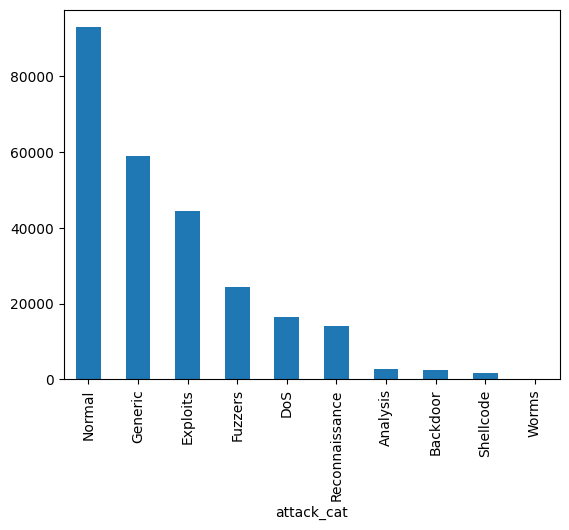

In [91]:
df['attack_cat'].value_counts().plot.bar()

In [92]:
df['attack_cat'] = df['attack_cat'].replace(['Normal', 'Generic', 'Exploits','Fuzzers', 'DoS','Reconnaissance', 'Analysis', 'Backdoor', 'Shellcode', 'Worms'], ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
df['attack_cat'] = df['attack_cat'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 257673 entries, 0 to 175340
Data columns (total 42 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 257673 non-null  int64  
 1   dur                257673 non-null  float64
 2   spkts              257673 non-null  int64  
 3   dpkts              257673 non-null  int64  
 4   sbytes             257673 non-null  int64  
 5   dbytes             257673 non-null  int64  
 6   rate               257673 non-null  float64
 7   sttl               257673 non-null  int64  
 8   dttl               257673 non-null  int64  
 9   sload              257673 non-null  float64
 10  dload              257673 non-null  float64
 11  sloss              257673 non-null  int64  
 12  dloss              257673 non-null  int64  
 13  sinpkt             257673 non-null  float64
 14  dinpkt             257673 non-null  float64
 15  sjit               257673 non-null  float64
 16  djit   

# Upscale samples for poisoning detection

In [93]:
# Separate the features and labels
y = df['attack_cat']
X = df.drop('attack_cat', axis=1)
# Create a dictionary to store the target number of samples for each class
target_samples = {0: 400000, 1: 100000}
# Initialize the SMOTE oversampler
smote = SMOTE(sampling_strategy=target_samples)
# Upsample the dataset
X_resampled, y_resampled = smote.fit_resample(X, y)
# Create a new DataFrame with the resampled data
df_resampled = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled, columns=['attack_cat'])], axis=1)
# Verify the class distribution after upsampling
print(df_resampled['attack_cat'].value_counts())

/home/haku/.local/lib/python3.10/site-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (400000) in class 0 will be larger than the number of samples in the majority class (class #0 -> 93000)
  warnings.warn(
/home/haku/.local/lib/python3.10/site-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (100000) in class 1 will be larger than the number of samples in the majority class (class #0 -> 93000)
  warnings.warn(


attack_cat
0    400000
1    100000
2     44525
3     24246
4     16353
5     13987
6      2677
7      2329
8      1511
9       174
Name: count, dtype: int64


In [94]:
df_resampled

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label,attack_cat
0,1,0.000011,2,0,496,0,90909.0902,254,0,180363632.0,...,1,2,0,0,0,1,2,0,0,0
1,2,0.000008,2,0,1762,0,125000.0003,254,0,881000000.0,...,1,2,0,0,0,1,2,0,0,0
2,3,0.000005,2,0,1068,0,200000.0051,254,0,854400000.0,...,1,3,0,0,0,1,3,0,0,0
3,4,0.000006,2,0,900,0,166666.6608,254,0,600000000.0,...,1,3,0,0,0,2,3,0,0,0
4,5,0.000010,2,0,2126,0,100000.0025,254,0,850400000.0,...,1,3,0,0,0,2,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605797,123406,0.000009,2,0,114,0,111111.1072,254,0,50666664.0,...,16,16,0,0,0,16,16,0,1,1
605798,139581,0.000002,2,0,114,0,500000.0013,254,0,228000000.0,...,16,25,0,0,0,16,25,0,1,1
605799,134574,0.000008,2,0,114,0,125000.0003,254,0,57000000.0,...,10,13,0,0,0,13,13,0,1,1
605800,128693,0.000009,2,0,114,0,111111.1072,254,0,50666664.0,...,15,29,0,0,0,18,29,0,1,1


# Print dataset to files with expected format

In [95]:
# Print the label column into Y_attack.npy
y = df_resampled["attack_cat"].to_numpy()
np.save("Y_attack.npy", y)
# Print others columns into X.npy
X = df_resampled.drop(["attack_cat"], axis=1).to_numpy()
np.save("X.npy", X)

## Checking for duplicates

In [96]:
print(df.duplicated().sum())

0


There is no duplicate record.

## Checking for missing values

In [97]:
print(df.isna().sum())

id                   0
dur                  0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat           0
label                0
dtype: int64


There is no missing value.

## Checking the balance between benign and attack data

<Axes: xlabel='label'>

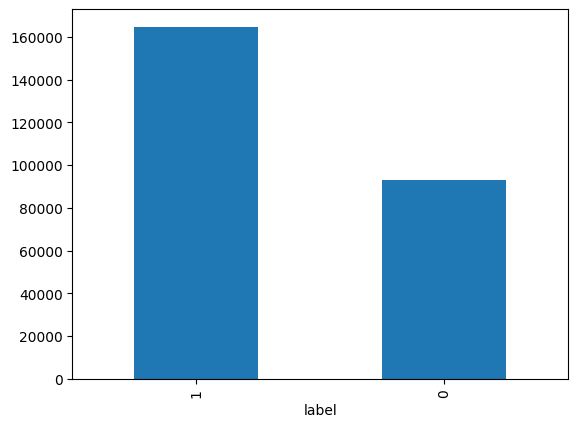

In [98]:
df['label'].value_counts().plot.bar()

In [99]:
df['label'].value_counts(normalize=True)

label
1    0.639077
0    0.360923
Name: proportion, dtype: float64

The ratio between attack and normal data is not equal, but just slightly imbalanced.
Therefore, we will not do a sampling fix here.